In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import random
import warnings
import multiprocessing as mp
from functools import partial
from scipy.integrate import quad, IntegrationWarning
import time
from datetime import date, time, datetime
from concurrent.futures import ThreadPoolExecutor


# Import files
from constants import *
from rotation import*
from pdfpy import *
from functions import  d_sigma, d_sigma_sm, sigma_sm, sme, sigma_full, summation_terms, integrate_sigma_hat_prime_sm, integrate_sigma_hat_prime_sme, dsigma_dQ, dsigma_dQ_1,dsigma_dQ_2,dsigma_dQ_3

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
quarks = [
    (2, 2/3*e, 'u', 1/2),
     (1, -1/3*e, 'd', -1/2),
     # (3, -1/3*e, 's', -1/2),
     # (4, 2/3*e, 'c', 1/2),
     #  (5, -1/3*e, 'b', -1/2),
     # (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 10)
    g_fR = round(g_fR, 10)
    g_fL = round(g_fL, 10)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2018666667, -0.046673592, 0.453326408), (1, -0.1009333333, 0.023336796, -0.476663204)]


In [27]:
quark_couplings1 = [(2, 0.2018666667, -0.046673592, 0.453326408)]
quark_couplings2 = [(1, -0.1009333333, 0.023336796, -0.476663204)]

In [25]:
#Don't foregt the metric convenction (+, -, -, -)
g = tn.tensor([
    [1,0,0,0],
    [0,-1,0,0],
    [0,0,-1,0],
    [0,0,0,-1]
], dtype=tn.float32)
CL1 = tn.tensor([
    [0, 0, 0, 0],
    [0, 1e-4, 0, 0],
    [0, 0, -1e-4, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL2 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, -1e-4, 0],
    [0, -1e-4, 0, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL3 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, -1e-4],
    [0, 0, 0, 0],
    [0,-1e-4, 0, 0]
], dtype=tn.float32)
CL4 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, -1e-4],
    [0,0,-1e-4, 0]
], dtype=tn.float32)

CLzz = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0,0,0, -1e-4]
], dtype=tn.float32)


CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

# C0 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ], dtype=tn.float32)

In [5]:
# Define the constant tensors once
p1 =  0.5*tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 =  0.5*tn.tensor([1, 0, 0, -1], dtype=tn.float32)

# Precompute total number of steps

specific_time = datetime(2017, 1, 1, 0, 0)

start_time = int(specific_time.timestamp())

# start_time = int(time.time())
end_time = start_time + int(timedelta(days=1).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrelep1 = []
contrelep2 = []

R_y_lat = R_y(latitude)
R_z_azi = R_z(azimuth)
mat_cons = tn.matmul(R_y_lat,R_z_azi)
# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 
    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    R_mat = tn.matmul(R_Z_omega, mat_cons)
    R_matrix1 = tn.einsum('ma,an->mn', g, R_mat)
    R_matrix2 = tn.einsum('am,na->mn', g, R_mat)
    # print(R_matrix1)
    # Compute contrL and contrR using matrix multiplication
    contrp1 = tn.einsum('ij,j->i', R_matrix1, p1)
    contrp2 =  tn.einsum('ij,i->j',R_matrix2, p2)
    # Record the times and contr matrix elements
    times.append(current_time)
    contrelep1.append(contrp1)
    contrelep2.append(contrp2)


    # Move to the next time step
    current_time += step_seconds

In [7]:
%%time

warnings.simplefilter("ignore", IntegrationWarning)

def compute_result(args, sigma_sm_value):
    pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR = args
    Q_min = 70
    Q_max = 80  
    
    # Compute the SME contributions
    result_sme1 = sme(Q_min, Q_max, CL1, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme2 = sme(Q_min, Q_max, CL2, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme3 = sme(Q_min, Q_max, CL3, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme4 = sme(Q_min, Q_max, CL4, CR, pm, pn, quark_couplings, sigma_sm_value)
    
    # Add the SM result to each of the SME results after the loop
    final_result_sme1 = result_sme1 + sigma_sm_value
    final_result_sme2 = result_sme2 + sigma_sm_value
    final_result_sme3 = result_sme3 + sigma_sm_value
    final_result_sme4 = result_sme4 + sigma_sm_value
    
    # Return the result as a dictionary
    return {
        'result_sme1': final_result_sme1,
        'result_sme2': final_result_sme2,
        'result_sme3': final_result_sme3,
        'result_sme4': final_result_sme4
    }

# Calculate sigma_sm once outside the loop since it doesn't depend on p1, p2, or CL.
Q_min = 70
Q_max = 80
sigma_sm_value = sigma_sm(Q_min, Q_max, quark_couplings)

# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result = partial(compute_result, sigma_sm_value=sigma_sm_value)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results = pool.map(partial_compute_result, args_list)

# Function to convert timestamps to hours
def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

CPU times: user 55.8 s, sys: 180 ms, total: 56 s
Wall time: 6min 19s


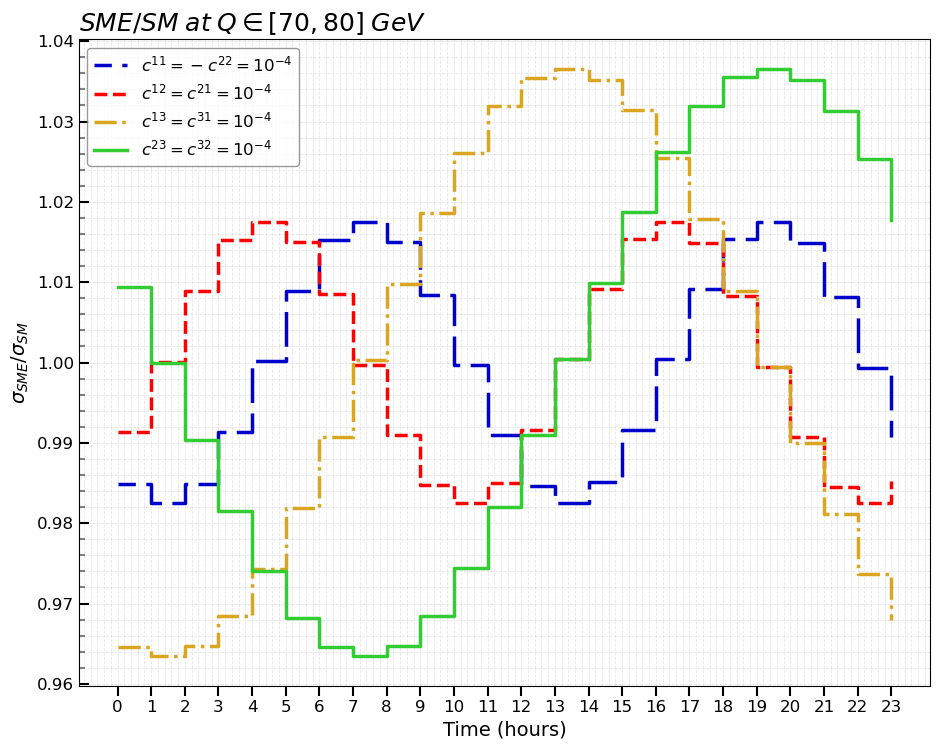

In [47]:
import matplotlib.colors as mcolors
dratios = [np.array([result[f'result_sme{i+1}'] / sigma_sm_value for result in results]) for i in range(4)]
hours_array = np.array(hours_start)
plt.figure(figsize=(10, 8))
colors = ['mediumblue', 'red', 'goldenrod','limegreen' ]
# Increase line width and adjust line styles for differentiation
line_styles = [(5, (10, 3)), '--', '-.', '-']
labels=['$c^{11}=-c^{22}=10^{-4}$','$c^{12}=c^{21}=10^{-4}$','$c^{13}=c^{31}=10^{-4}$','$c^{23}=c^{32}=10^{-4}$']

for i in range(4):
    plt.step(hours_array, dratios[i], where='post', color=colors[i], label=labels[i], linewidth=2.5, linestyle=line_styles[i])

# Customizing the legend: move it inside the plot area, adjust font size, and add a background
plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, framealpha=0.8, edgecolor='gray')

# Adding labels and title with increased font size for clarity
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel(r'$\sigma_{SME}/\sigma_{SM}$', fontsize=14)
plt.title(r'$SME/SM \; at \; Q \in [70,80] \; GeV$', fontsize=18, loc='left')

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.3)

# Adjust tick parameters for better readability
plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)  
plt.tick_params(which='both', width=1.5)
plt.tick_params(which='major', length=7, labelsize=12)
plt.tick_params(which='minor', length=4, color='gray')
plt.tick_params(axis='y', direction='in', which='both', labelsize=12) 

# Customize x-ticks
plt.xticks(ticks=range(0, 24, 1), labels=[str(hour) for hour in range(0, 24, 1)])

# Adjust layout to prevent clipping of labels and title
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

# Save and show the plot
plt.savefig("liv.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

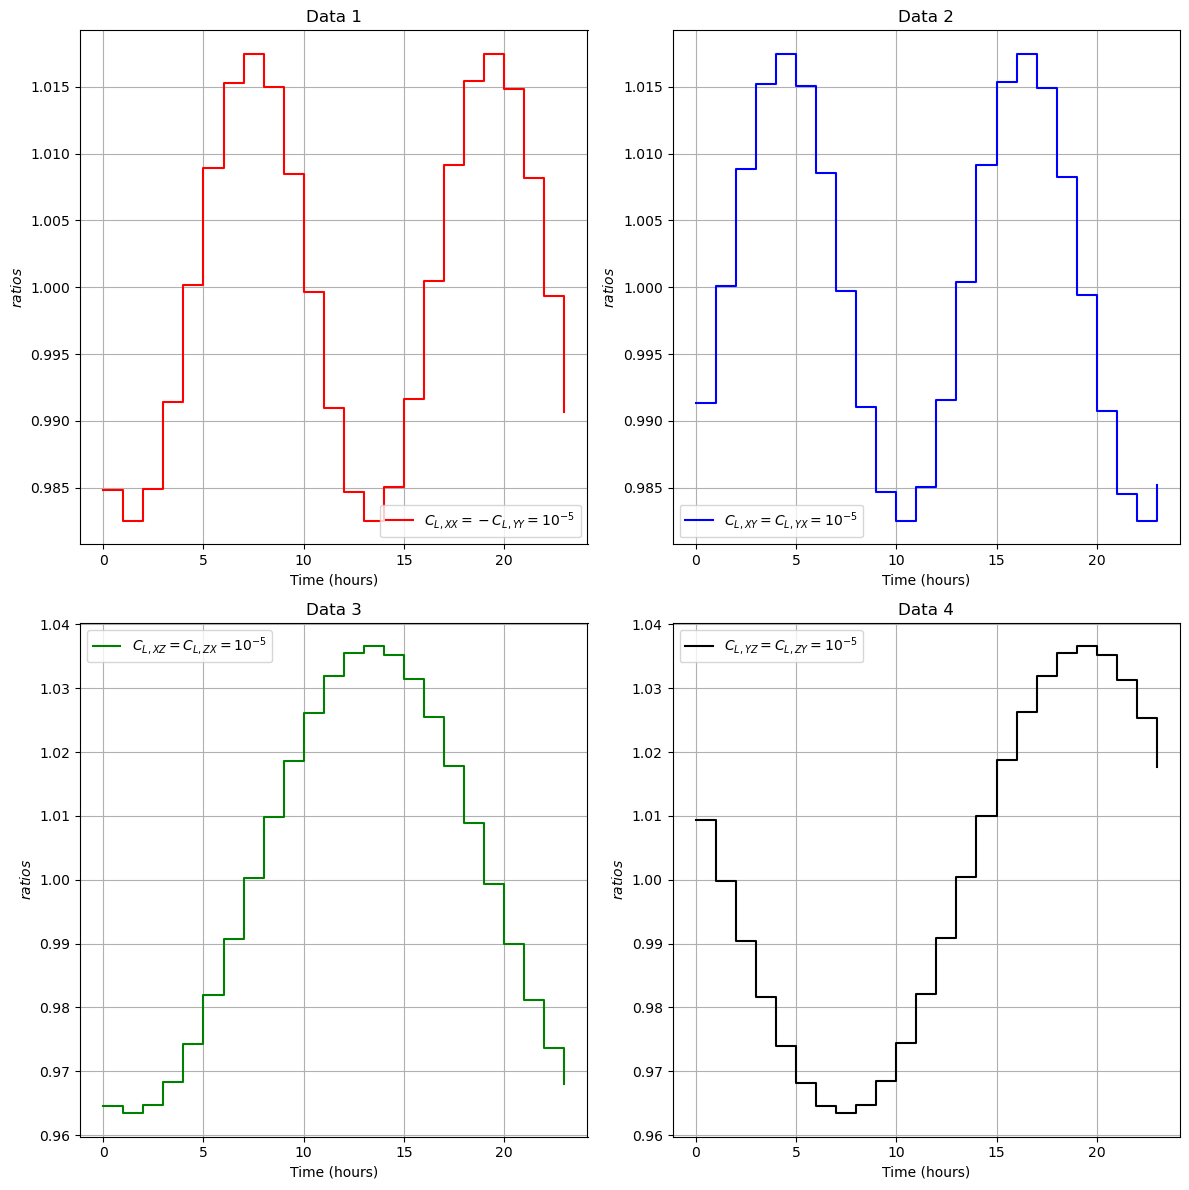

In [23]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot data in each subplot
axs[0, 0].step(hours_array, dratios[0], where='post', color='r', label='$C_{L,XX} = - C_{L,YY} = 10^{-5}$')
axs[0, 0].set_title('Data 1')
axs[0, 0].set_xlabel('Time (hours)')
axs[0, 0].set_ylabel('$ratios$')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].step(hours_array, dratios[1], where='post', color='b', label='$C_{L,XY} = C_{L,YX} = 10^{-5}$')
axs[0, 1].set_title('Data 2')
axs[0, 1].set_xlabel('Time (hours)')
axs[0, 1].set_ylabel('$ratios$')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].step(hours_array, dratios[2], where='post', color='g', label='$C_{L,XZ} = C_{L,ZX} = 10^{-5}$')
axs[1, 0].set_title('Data 3')
axs[1, 0].set_xlabel('Time (hours)')
axs[1, 0].set_ylabel('$ratios$')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].step(hours_array, dratios[3], where='post', color='black', label='$C_{L,YZ} = C_{L,ZY} = 10^{-5}$')
axs[1, 1].set_title('Data 4')
axs[1, 1].set_xlabel('Time (hours)')
axs[1, 1].set_ylabel('$ratios$')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_sme_for_bin(Q_range):
    # Unpack the tuple
    Q_start, Q_end = Q_range
    # Function to compute SME for a given range
    return sme(Q_start, Q_end, CLzz, CLzz, p1, p2, quark_couplings1)

if __name__ == '__main__':
    Q_val = np.linspace(17.5, 90, 100)
    a = 17.5  # Start of the Q range
    b = 90  # End of the Q range
    nbins = 17  # Number of bins

    Q_bins = np.linspace(a, b, nbins + 1)

    # Prepare the list of arguments for each bin
    bin_ranges = [(Q_bins[i], Q_bins[i + 1]) for i in range(len(Q_bins) - 1)]

    # Use multiprocessing to compute SME values
    with mp.Pool() as pool:
        sme_values1 = pool.map(compute_sme_for_bin, bin_ranges)

CPU times: user 45.9 ms, sys: 204 ms, total: 250 ms
Wall time: 3min 28s


In [29]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_sme_for_bin(Q_range):
    # Unpack the tuple
    Q_start, Q_end = Q_range
    # Function to compute SME for a given range
    return sme(Q_start, Q_end, CLzz, CLzz, p1, p2, quark_couplings2)

if __name__ == '__main__':
    Q_val = np.linspace(17.5, 90, 100)
    a = 17.5  # Start of the Q range
    b = 90  # End of the Q range
    nbins = 17  # Number of bins

    Q_bins = np.linspace(a, b, nbins + 1)

    # Prepare the list of arguments for each bin
    bin_ranges = [(Q_bins[i], Q_bins[i + 1]) for i in range(len(Q_bins) - 1)]

    # Use multiprocessing to compute SME values
    with mp.Pool() as pool:
        sme_values2 = pool.map(compute_sme_for_bin, bin_ranges)

CPU times: user 43.1 ms, sys: 199 ms, total: 242 ms
Wall time: 3min 40s


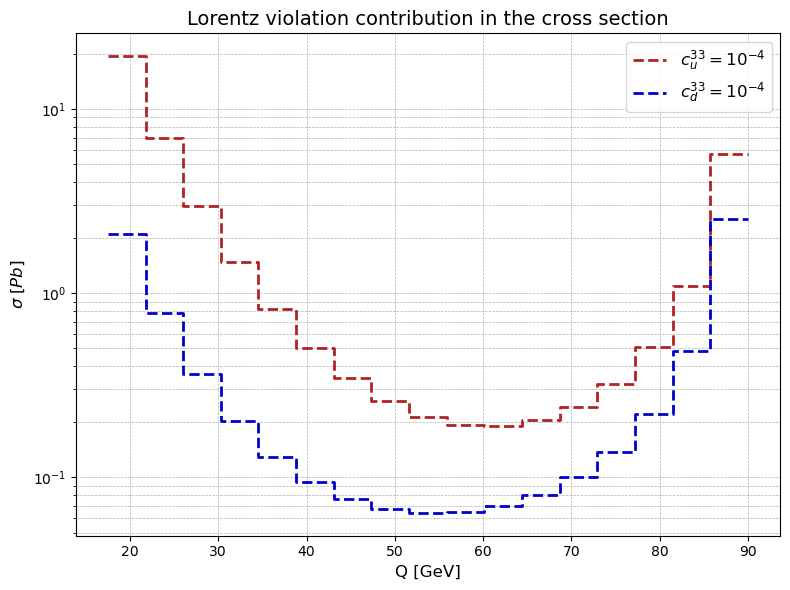

In [46]:
plt.figure(figsize=(8, 6))

# Create the step plot
plt.step(Q_bins, sme_values1 + [sme_values1[-1]], where='post', color='firebrick', linestyle='--', linewidth=2, label=r'$c_{u}^{33} = 10^{-4}$')
plt.step(Q_bins, sme_values2 + [sme_values2[-1]], where='post', color='mediumblue', linestyle='--', linewidth=2, label=r'$c_{d}^{33} = 10^{-4}$')

plt.xlabel('Q [GeV]', fontsize=12)
plt.yscale('log')
plt.ylabel('$\\sigma \\;[Pb]$', fontsize=12)
plt.title('Lorentz violation contribution in the cross section', fontsize=14)

# Add grid with both major and minor ticks
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add a legend
plt.legend(fontsize=12, loc='best')

# Improve layout
plt.tight_layout()

# Save and show the plot
plt.savefig('intersec.png', dpi=300)
plt.show()

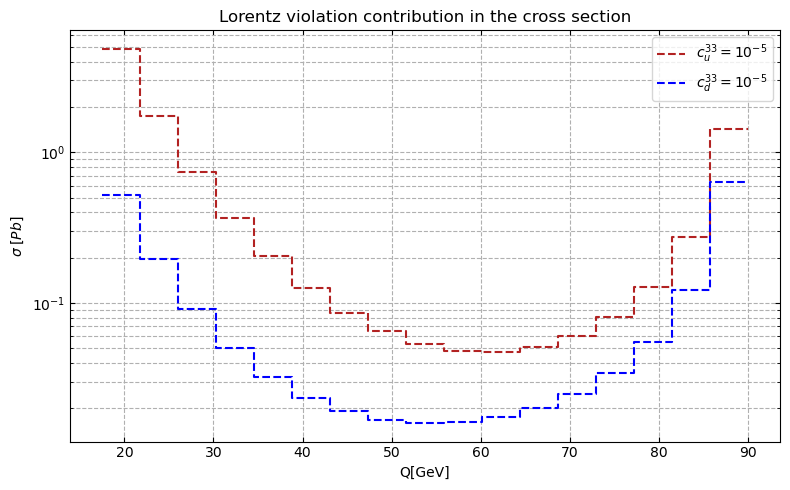

In [108]:
plt.figure(figsize=(8, 5))

# Create the step plot
plt.step(Q_bins,  sme_values1 + [sme_values1[-1]], where='post', color='firebrick', linestyle='--', label = '$c^{33}_{u}=10^{-5}$')
plt.step(Q_bins,  sme_values2 + [sme_values2[-1]], where='post', color='blue', linestyle='--', label = '$c^{33}_{d}=10^{-5}$')


plt.xlabel('Q[GeV]')
plt.yscale('log')
plt.ylabel('$\\sigma \\;[Pb]$')
plt.title('Lorentz violation contribution in the cross section')
plt.grid(True, which="both", ls="--")  

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)


plt.tight_layout()
plt.legend()
# Save and show the plot
plt.savefig('intrsec.png')
plt.show()



## SM predictions for the Drell-Yan process

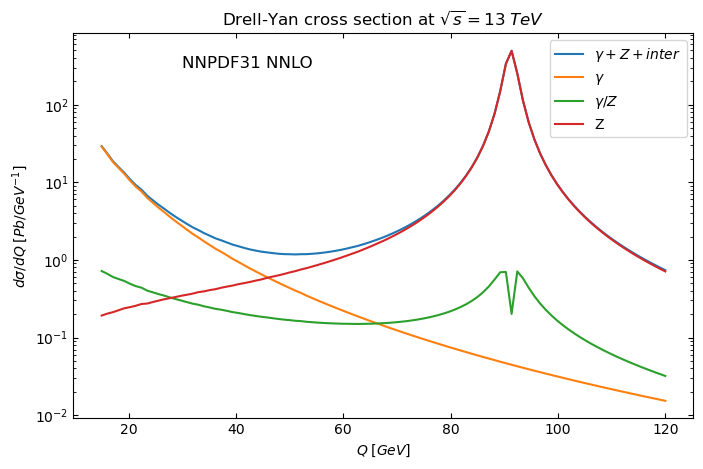

In [9]:
Q_val = np.linspace(15, 120, 100)
all = [dsigma_dQ(Q**2, quark_couplings) for Q in Q_val]
gamma = [dsigma_dQ_1(Q**2, quark_couplings) for Q in Q_val]
gammaZ = [dsigma_dQ_2(Q**2, quark_couplings) for Q in Q_val]
Z = [dsigma_dQ_3(Q**2, quark_couplings) for Q in Q_val]

plt.figure(figsize=(8, 5))

# Plot all datasets with labels for the legend
plt.plot(Q_val, all, label='$\\gamma+Z+inter$')
plt.plot(Q_val, gamma, label='$\\gamma$')
plt.plot(Q_val, gammaZ, label='$\\gamma/Z$')
plt.plot(Q_val, Z, label='Z')

# Set the labels
plt.xlabel('$Q\;[GeV]$')
plt.yscale('log')
plt.ylabel('$d\\sigma/dQ \\;[Pb/GeV^{-1}]$')
plt.title('Drell-Yan cross section at $\\sqrt{s}= 13\;TeV$')

# Enable ticks on all four borders
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Add text inside the plot
plt.text(30, max(all) * 0.7, 'NNPDF31 NNLO', fontsize=12, color='black')

# Show legend
plt.legend()

# Save the figure
plt.savefig('drellyan.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
